# Under ice chlorophyll-a, oxygen and nitrate analysis

### Import packages

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import glob
import seawater as sw
from soccom_functions import *
import pickle 
import datetime
import xarray as xr
import pandas as pd 
import plotly.graph_objs as go
import cmocean

### Read float data

For a single float

In [3]:
file_folder = "../../data/raw/WGfloats/" # specify directory relative to location of notebook
float_number = "5904397" #7900918 #9094

files = sorted(glob.glob(file_folder+"/*"+float_number+"*.nc"))
print(files)
#files = sorted(glob.glob(file_folder+"/*.nc"))

NameError: name 'glob' is not defined

NameError: name 'files' is not defined

### Loads and grids data from single float

In [3]:
#uses the function that reads and grids the data
FLOAT = grids_one_buoy(files[0],display_info = False, DO_ml_crit = 2.5, clear_short = True)

#the gridded data is located in the dictionary FLOAT.gr, and contains the following variables
print(FLOAT.gr.keys())
print(FLOAT.raw_bg.keys())
#some of them are standard and others related to thorpe scales and mixing, and you also have geopotential anomalies (gpa) integrated between 500 and 1500 m (gpa_500_1500)

print("This float is WMO code: %s"%(FLOAT.gr["WMO_code"]))


#fmet = open("float_pickles/ERA_hr_"+FLOAT.raw["code"]+".pi","rb")
#FLOAT.methr = pickle.load( fmet )
#FLOAT.methr["time64"] = np.copy( FLOAT.methr["time"] )
#FLOAT.methr["time"] = convert_datetime64_to_time(FLOAT.methr["time64"])
#FLOAT.methr["date"] = convert_datetime64_to_date(FLOAT.methr["time64"])
#FLOAT.calculates_carbon_framework(sp = FLOAT.methr["sp"], timemet = FLOAT.methr["time"], ML_zero = False)
#CFvars = FLOAT.gr["CF"].keys()

#carbon flux
#FLOAT.calculates_CO2_O2_flux(FLOAT.methr)

C:\Users\Clara Douglas\OneDrive - University of Southampton\PhD\Projects\net_community_production\notebooks\FromBieito\soccom_functions.py:338: RuntimeWarning: Mean of empty slice
  self.gr["LT"][j,i] = np.nanmean(disp[jj]**2)**0.5


dict_keys(['depth', 'date', 'date_dt', 'Lon', 'Lat', 'code', 'WMO_code', 'Pressure', 'Temperature', 'Salinity', 'SA', 'CT', 'Sigma_theta', 'gamma_n', 'N2', 'PV', 'Oxygen', 'OxygenSat', 'Nitrate', 'DIC_LIAR', 'TALK_LIAR', 'pCO2_LIAR', 'Chl_a', 'Chl_a_corr', 'POC', 'LT', 'mld', 'mld_HT', 'mld_DO', 'LT_ml', 'LT_ov', 'LT_largest_ov', 'size_largest_ov', 'h_largest_ov', 'h_no_ov', 'gpa', 'gpa_500_1500', 'AOU'])
dict_keys(['Oxygen', 'OxygenSat', 'Nitrate', 'DIC_LIAR', 'TALK_LIAR', 'pCO2_LIAR', 'Chl_a', 'Chl_a_corr', 'POC'])
This float is WMO code: 5904397


## Initial plot of the float main variables and position

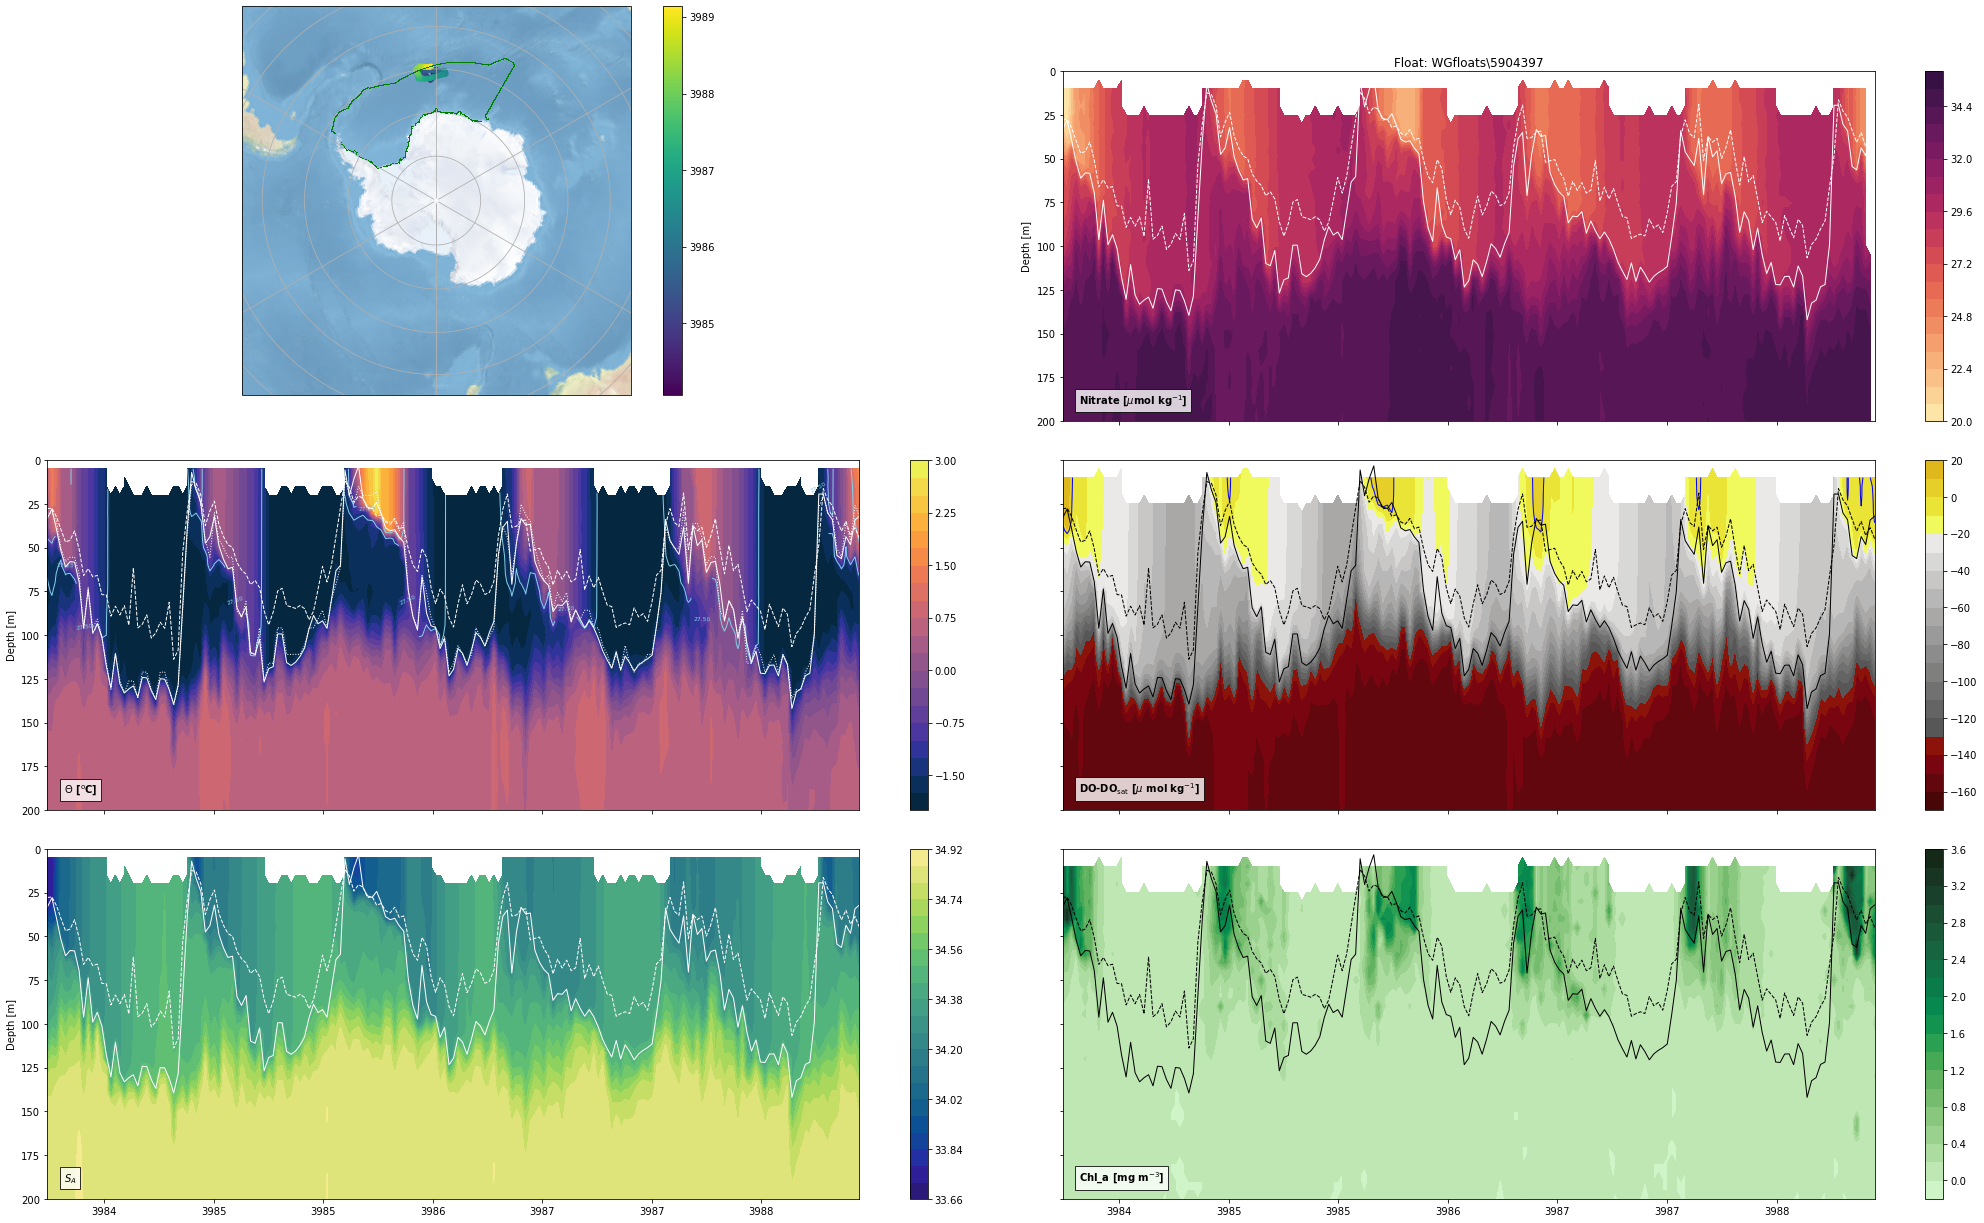

In [4]:
%matplotlib inline 
#qt
studyarea=pd.read_csv('../../data/processed/ANDREXbox.csv',header=None).values

#with this command you can have an overview of the float data 
FLOAT.plots_map_main_variables(studyarea, shows = True, saves = False,  ylim=  (200,0))
#FLOAT.plots_mixing_layer_profile(20, show = True)

#plt.plot(FLOAT.gr["date"],FLOAT.gr["gpa_500_1500"])

## Calculate max (and mean in ML) chl in profiles

In [4]:
H = np.nanmax(FLOAT.gr["mld"]) # calculates the maximum ML
print("Deepest mixed layer: %1.0f m"%(H))

jh = np.where( FLOAT.gr["depth"]>= H)[0][0] # gets the depth index for the maxmum mixed layer ([0][0] requests the first instance - so the shallowest depth point that is greater or equal to MLD)

print(jh)
# maximum chl in water column
max_Chl_a = np.nanmax(FLOAT.gr["Chl_a"][:,:], axis = 0)
max_Chl_a_corr = np.nanmax(FLOAT.gr["Chl_a_corr"][:,:], axis = 0)
meanML_Chl_a = np.nanmean(FLOAT.gr["Chl_a_corr"][:jh,:], axis = 0)

print(np.nanmax(max_Chl_a))
print(np.nanmax(max_Chl_a_corr))

Deepest mixed layer: 142 m
29
3.4408347899872727
1.1469449299957575


In [67]:
uplim=1
deeplim=100
lowlim=200 # check what values of chl_a there are deeper than 150m - 
            #there shouldn't be any, so may indicate some callibration error/uncertainty if there is, and need to correct for that
Uh = np.where( FLOAT.gr["depth"]>= uplim)[0][0]
Dh = np.where( FLOAT.gr["depth"]>= deeplim)[0][0]
Lh = np.where( FLOAT.gr["depth"]>= lowlim)[0][0]

In [68]:
#get time/dates
nt = FLOAT.gr["date"].size
dateDT = convert_time_to_date( FLOAT.gr["date"] )
year = np.full( nt, np.nan )
month = np.full(nt, np.nan)
for i in range(nt):
    year[i] = dateDT[i].year
    month[i] = dateDT[i].month

In [102]:
# calculate the vertically integrated data column inventory using the composite trapezoidal rule
def integrate(zi, data, depth_range):
    n_depths,n_profs=data.shape
    #n_profs = len(data)
    zi_start = abs(zi - depth_range[0]).argmin() # find location of start depth
    zi_end =  abs(zi - depth_range[1]).argmin() # find location of end depth
    zi_struct = np.ones((n_profs, 1)) * zi[zi_start : zi_end] # add +1 to get the 200m value
    data = data[ zi_start : zi_end,:] # add +1 to get the 200m value
    col_inv = []
    for n in range(0, n_profs):#len(data)):
        col_inv.append(np.trapz(data[:,n][~np.isnan(data[:,n])], zi_struct[n,:][~np.isnan(data[:,n])]))
    return col_inv
#np.trapz?
#print(len(FLOAT.gr["Nitrate"]))

In [105]:
# Interpolate nitrate and poc
zi = np.arange(0, 2005, 5) # 5 = 320 depth intervals between 0m to 1595m
#nitr_int = interpolate(zi, fd.Pressure[:, ::-1], fd.Nitrate[:, ::-1]) # interpolate nitrate values across zi depth intervals for all 188 profiles
# Integrate nitrate and poc - total nitrate in upper 200m
upperlim=1
lowerlim=200
nitr = np.array(integrate(zi, FLOAT.gr["Nitrate"], [upperlim, lowerlim])) # integrate interpolated nitrate values between 25m-200m 
print(np.round((nitr[40:60]/1000),4))
dint_Nitrate = np.nanmean(FLOAT.gr["Nitrate"][Uh:Lh,:], axis = 0)*H*(1027/1e6)
print(np.round((dint_Nitrate[40:60]),4))

print(len(nitr))
print(len(dint_Nitrate))
#print(np.diff(np.round((nitr[0:10]/1000),4)))
#print(np.diff(np.round((dint_Nitrate[0:10]),4)))

[5.8008 5.8399 5.5832 5.6195 5.6623 5.5569 5.5844 5.6824 5.6292 5.2495
 5.2375 5.318  5.3197 5.1464 5.2981 5.3283 5.5022 5.3935 5.4238 5.4176]
[4.4505 4.4814 4.4028 4.4308 4.4643 4.3833 4.4061 4.4822 4.4416 4.5067
 4.4974 4.5635 4.5654 4.552  4.5485 4.5741 4.5882 4.6294 4.6547 4.6494]
181
181


C:\Users\ccd1n18\AppData\Local\Temp/ipykernel_3640/640036355.py:9: RuntimeWarning: Mean of empty slice
  dint_Nitrate = np.nanmean(FLOAT.gr["Nitrate"][Uh:Lh,:], axis = 0)*H*(1027/1e6)


In [ ]:
print(FLOAT.gr["Nitrate"][Uh:Lh,179:])
np.trapz?
depths,profs=FLOAT.gr["Nitrate"].shape
print(profs)

[[        nan         nan]
 [        nan         nan]
 [        nan         nan]
 [        nan         nan]
 [        nan         nan]
 [        nan         nan]
 [        nan         nan]
 [        nan         nan]
 [        nan         nan]
 [        nan         nan]
 [        nan         nan]
 [        nan         nan]
 [        nan         nan]
 [        nan         nan]
 [        nan         nan]
 [        nan         nan]
 [        nan         nan]
 [        nan         nan]
 [        nan         nan]
 [        nan         nan]
 [31.36840264         nan]
 [32.02021782         nan]
 [32.38251474         nan]
 [32.70443218         nan]
 [33.02634962         nan]
 [33.34826706         nan]
 [33.67018449         nan]
 [33.99210193         nan]
 [34.31401937         nan]
 [34.5291142          nan]
 [34.63050604         nan]
 [34.71794894         nan]
 [34.77500214         nan]
 [34.83205534         nan]
 [34.88910854         nan]
 [34.94106049         nan]
 [34.95087981         nan]
 

Signature: np.trapz(y, x=None, dx=1.0, axis=-1)
Docstring:
Integrate along the given axis using the composite trapezoidal rule.

Integrate `y` (`x`) along given axis.

Parameters
----------
y : array_like
    Input array to integrate.
x : array_like, optional
    The sample points corresponding to the `y` values. If `x` is None,
    the sample points are assumed to be evenly spaced `dx` apart. The
    default is None.
dx : scalar, optional
    The spacing between sample points when `x` is None. The default is 1.
axis : int, optional
    The axis along which to integrate.

Returns
-------
trapz : float
    Definite integral as approximated by trapezoidal rule.

See Also
--------
sum, cumsum

Notes
-----
Image [2]_ illustrates trapezoidal rule -- y-axis locations of points
will be taken from `y` array, by default x-axis distances between
points will be 1.0, alternatively they can be provided with `x` array
or with `dx` scalar.  Return value will be equal to combined area under
the red li

How much chl-a recorded below 150m?

In [17]:
deep_Chl_a = np.nanmax(FLOAT.gr["Chl_a_corr"][Lh:,:], axis = 0)
#max_Chl_a_corr = np.nanmax(FLOAT.gr["Chl_a_corr"][Uh:Dh,:], axis = 0)
#meanML_Chl_a = np.nanmean(FLOAT.gr["Chl_a_corr"][:jh,:], axis = 0)
print('Absolute maximum chl-a measurement below 150m:',np.round(np.nanmax(deep_Chl_a),5),'mg m^{-3}')
print('Average of the maximum chl-a measurement below 150m:',np.round(np.nanmean(deep_Chl_a),5),'mg m^{-3}')

Absolute maximum chl-a measurement below 150m: 0.2385 mg m^{-3}
Average of the maximum chl-a measurement below 150m: 0.00765 mg m^{-3}


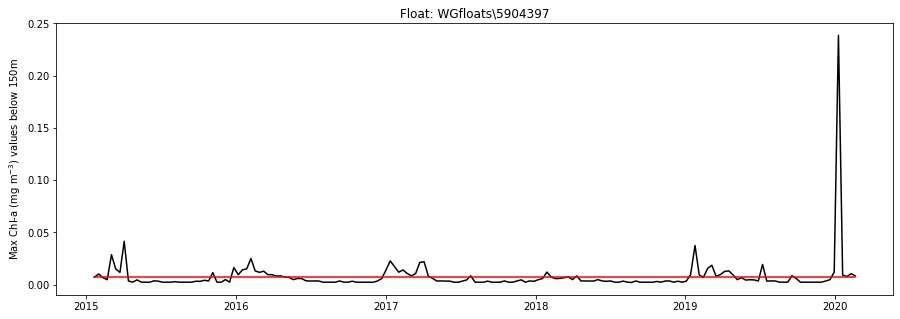

In [45]:
fig, ax = plt.subplots(figsize = (15,5), sharex = True)
#fig,(ax1,ax2)=plt.figure(figsize = (15,5))
plt.plot( FLOAT.gr["date_dt"], deep_Chl_a, "k" )
ax.set_ylabel( "Max Chl-a (mg m$^{-3}$) values below 150m" )
mean_deep_chl_a=[np.nanmean(deep_Chl_a)]*len(FLOAT.gr["date"])
plt.plot(FLOAT.gr["date_dt"], mean_deep_chl_a, "r")
ax.set_title("Float: %s"%(FLOAT.raw["code"]))

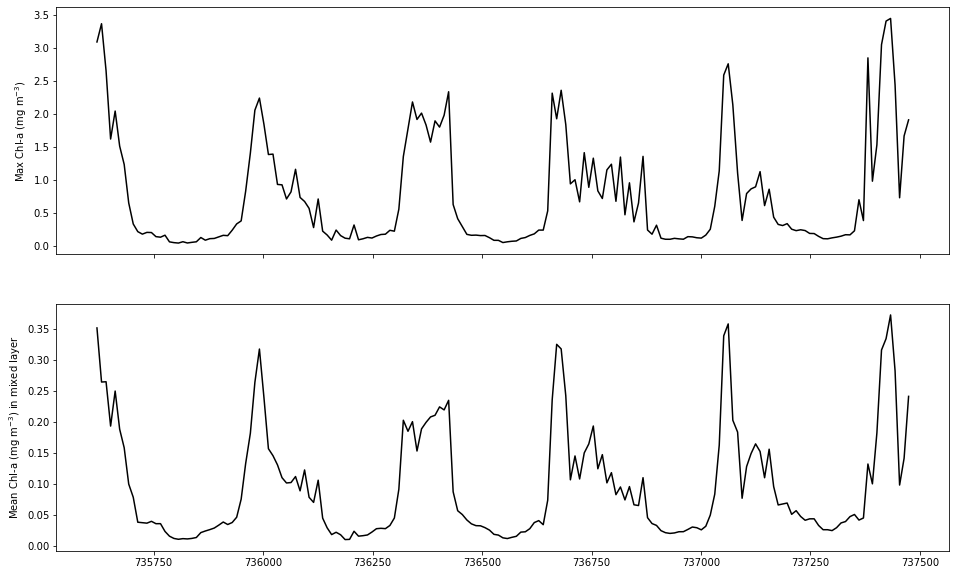

In [5]:
fig, ax = plt.subplots(2,1,figsize = (16,10), sharex = True)
ax[0].plot( FLOAT.gr["date"], max_Chl_a, "k" )
ax[0].set_ylabel( "Max Chl-a (mg m$^{-3}$)" )
ax[1].plot( FLOAT.gr["date"], meanML_Chl_a, "k" )
ax[1].set_ylabel( "Mean Chl-a (mg m$^{-3}$) in mixed layer" )
ax[1].format_xdata = mdates.DateFormatter('%Y-%m')
#ax[1].xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))

### Read in all floats from a directory

In [ ]:
#reads float data
file_folder = "../../data/raw/WGfloats/" # specify directory relative to location of notebook

files = sorted(glob.glob(file_folder+"/*.nc"))
print(files)

In [ ]:
for f_ix in range(0,len(files)):
    FLOAT = grids_one_buoy(files[f_ix],display_info = False, DO_ml_crit = 2.5, clear_short = True)
    #the gridded data is located in the dictionary FLOAT.gr, and contains the following variables
    print(FLOAT.gr.keys())
    #some of them are standard and others related to thorpe scales and mixing, and you also have geopotential anomalies (gpa) integrated between 500 and 1500 m (gpa_500_1500)
    print("This float is WMO code: %s"%(FLOAT.gr["WMO_code"]))
    
    NEPt,NEP_avgt,Uyeart=calc_NEP(FLOAT)
    
    str_t=FLOAT.gr["WMO_code"]+"_NEP"
    str_av=FLOAT.gr["WMO_code"]+"_NEPav"
    
    df = pd.DataFrame(NEPt, columns = [str_t], index = [Uyeart])
    NEPdf=pd.concat([NEPdf,df],axis=1)
    dfav = pd.DataFrame(NEP_avgt, columns = [str_av], index = [Uyeart])
    NEPavdf=pd.concat([NEPavdf,dfav],axis=1)
    
    
    
    #make a map of float trajectory
    #ax0 = fig.add_axes([0.10,0.67,0.3,0.3], projection = proj) #ax0 = fig.add_axes([0.10,0.1,0.7,0.7], projection = proj)
    #ax0.gridlines(draw_labels=False)
    #ax0.set_extent([-180, 180, -90, -45], crs.PlateCarree()) # originally -25 as north extent, will shorten to -45
    #ax0.stock_img()
    #cc = ax0.scatter(FLOAT.raw["Lon"], FLOAT.raw["Lat"], 20, c = FLOAT.raw["date"],transform = crs.PlateCarree(),)#-self.raw["date"][0])
    #loc = mdates.AutoDateLocator()
    #fig.colorbar(cc, ticks=loc,format=mdates.AutoDateFormatter(loc))
    #box = ax0.plot([studyarea[:,0]],[studyarea[:,1]],transform = crs.PlateCarree(),color='green', marker=',', linestyle='dashed',linewidth=1.5, markersize=1.5)
    

       
#print(NEPdf)
#print(NEPavdf)
plt.show()
NEP_nitrate=pd.concat([NEPdf,NEPavdf],axis=1)
print(NEP_nitrate)